# Análisis de Componentes Principales (PCA) y Detección de Outliers
## Datos Hidrológicos Completos

**Objetivo:** Aplicar técnicas de reducción de dimensionalidad (PCA) y detección de valores atípicos a los datos hidrológicos completos.

**Dataset:** `datos_hidrologicos_completos.csv` (1940-2024, ~31,000 registros)

**Metodología:**
1. Análisis Exploratorio de Datos (EDA)
2. Preprocesamiento de datos
3. Análisis de Componentes Principales (PCA)
4. Detección de Outliers (múltiples métodos)
5. Visualización y conclusiones

## 1. Importar Librerías

In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Librerías para PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Librerías para detección de outliers
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from scipy import stats

import matplotlib
print(f"Backend actual: {matplotlib.get_backend()}")

# Configurar estilo (usar default si otros fallan)
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('default')

sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
%matplotlib inline

print("✓ Librerías importadas exitosamente")

Backend actual: module://matplotlib_inline.backend_inline
✓ Librerías importadas exitosamente


## 2. Cargar y Explorar Datos

In [2]:
# Cargar datos
df = pd.read_csv('../data/processed/datos_hidrologicos_completos.csv')
df['fecha'] = pd.to_datetime(df['fecha'])

print(f"Dimensiones del dataset: {df.shape}")
print(f"\nPeriodo de datos: {df['fecha'].min()} a {df['fecha'].max()}")
print(f"Total de días: {len(df)}")
df.head()

Dimensiones del dataset: (31047, 20)

Periodo de datos: 1940-01-01 00:00:00 a 2024-12-31 00:00:00
Total de días: 31047


,fecha,almacenamiento_hm3,precipitacion_mm,lluvia_mm,evapotranspiracion_mm,temp_media_c,temp_max_c,temp_min_c,horas_precipitacion,viento_max_km_h,viento_medio_km_h,deficit_presion_vapor_kpa,radiacion_solar_mj_m2,humedad_relativa_pct,cobertura_nubes_pct,humedad_suelo_0_100cm,humedad_suelo_0_7cm,humedad_suelo_28_100cm,humedad_suelo_7_28cm,datos_completos
0,1940-01-01,NaN,0.0,0.0,3.19,15.5,23.7,7.9,0.0,11.9,6.8,2.33,14.54,42,41,0.053,0.053,0.051,0.062,False
1,1940-01-02,NaN,0.0,0.0,2.86,15.5,23.3,8.4,0.0,13.0,7.2,2.30,11.71,42,77,0.053,0.053,0.051,0.061,False
2,1940-01-03,NaN,0.0,0.0,3.68,17.0,25.5,9.5,0.0,18.2,9.7,2.60,14.10,42,63,0.053,0.052,0.051,0.061,False
3,1940-01-04,NaN,0.0,0.0,2.75,16.1,22.8,9.2,0.0,13.2,6.5,2.00,11.94,52,68,0.053,0.052,0.051,0.061,False
4,1940-01-05,NaN,0.1,0.1,2.19,15.1,21.0,10.0,1.0,19.8,11.3,1.38,8.83,66,78,0.053,0.052,0.051,0.061,False


In [3]:
# Información general del dataset
print("=" * 80)
print("INFORMACIÓN GENERAL DEL DATASET")
print("=" * 80)
df.info()

INFORMACIÓN GENERAL DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31047 entries, 0 to 31046
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   fecha                      31047 non-null  datetime64[ns]
 1   almacenamiento_hm3         24631 non-null  float64       
 2   precipitacion_mm           31047 non-null  float64       
 3   lluvia_mm                  31047 non-null  float64       
 4   evapotranspiracion_mm      31047 non-null  float64       
 5   temp_media_c               31047 non-null  float64       
 6   temp_max_c                 31047 non-null  float64       
 7   temp_min_c                 31047 non-null  float64       
 8   horas_precipitacion        31047 non-null  float64       
 9   viento_max_km_h            31047 non-null  float64       
 10  viento_medio_km_h          31047 non-null  float64       
 11  deficit_presion_vapor_kpa  31047 no

In [4]:
# Estadísticas descriptivas
print("=" * 80)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 80)
df.describe()

ESTADÍSTICAS DESCRIPTIVAS


,fecha,almacenamiento_hm3,precipitacion_mm,lluvia_mm,evapotranspiracion_mm,temp_media_c,temp_max_c,temp_min_c,horas_precipitacion,viento_max_km_h,viento_medio_km_h,deficit_presion_vapor_kpa,radiacion_solar_mj_m2,humedad_relativa_pct,cobertura_nubes_pct,humedad_suelo_0_100cm,humedad_suelo_0_7cm,humedad_suelo_28_100cm,humedad_suelo_7_28cm
count,31047,24631.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000
mean,1982-07-01 23:59:59.999999936,64.447475,0.564502,0.564502,5.727098,24.190466,31.442281,17.224972,0.824073,16.408593,9.186150,3.843011,21.838824,42.381100,28.426321,0.141138,0.097395,0.142603,0.150723
min,1940-01-01 00:00:00,0.000000,0.000000,0.000000,0.370000,3.500000,8.400000,-1.600000,0.000000,5.000000,2.500000,0.120000,1.240000,5.000000,0.000000,0.052000,0.010000,0.047000,0.061000
25%,1961-04-01 12:00:00,1.275000,0.000000,0.000000,4.060000,18.500000,26.400000,11.400000,0.000000,13.100000,7.500000,2.570000,16.690000,28.000000,1.000000,0.130000,0.071000,0.135000,0.128000
50%,1982-07-02 00:00:00,42.890000,0.000000,0.000000,5.670000,24.600000,32.100000,16.500000,0.000000,16.200000,8.900000,3.700000,22.230000,40.000000,18.000000,0.138000,0.073000,0.141000,0.138000
75%,2003-10-01 12:00:00,110.115000,0.000000,0.000000,7.375000,30.000000,36.900000,23.900000,0.000000,19.300000,10.500000,5.050000,27.000000,55.000000,49.000000,0.154000,0.099000,0.155000,0.161000
max,2024-12-31 00:00:00,300.320000,87.900000,87.900000,13.290000,39.200000,47.100000,30.900000,24.000000,55.000000,30.600000,10.060000,32.430000,97.000000,100.000000,0.291000,0.423000,0.262000,0.413000
std,NaN,69.911783,2.721520,2.721520,2.059888,6.658277,6.729381,6.821807,2.471372,4.300854,2.478845,1.639479,6.061070,17.918705,29.593004,0.032037,0.059712,0.034085,0.040228


ANÁLISIS DE VALORES FALTANTES
                    Valores Faltantes  Porcentaje (%)
almacenamiento_hm3               6416       20.665443


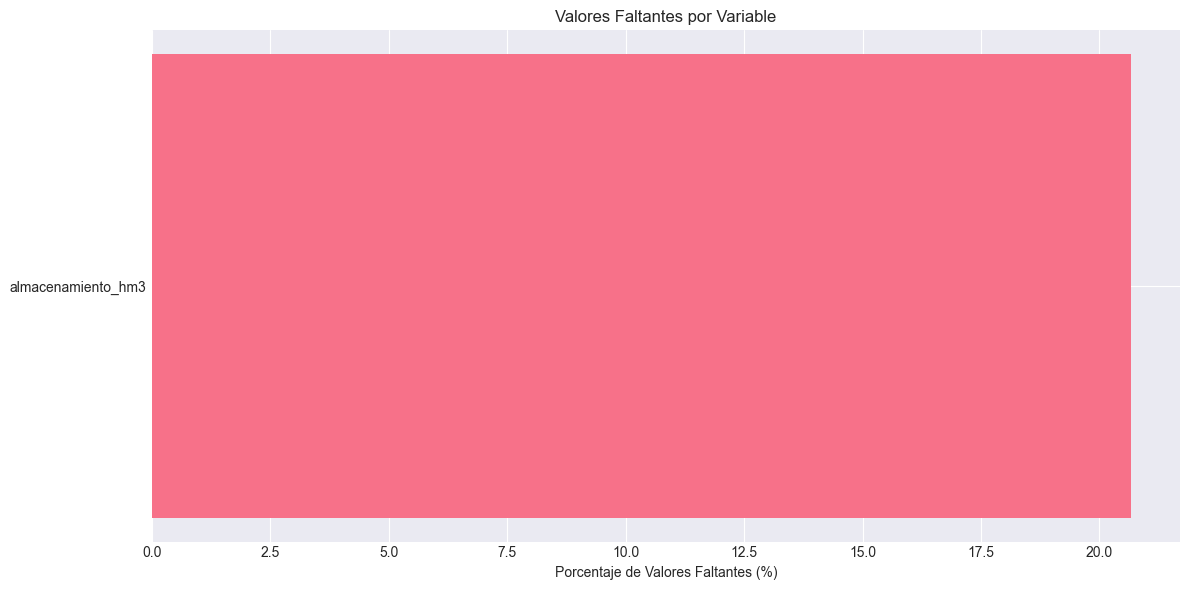

In [5]:
# Análisis de valores faltantes
print("=" * 80)
print("ANÁLISIS DE VALORES FALTANTES")
print("=" * 80)

missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Valores Faltantes': missing_values,
    'Porcentaje (%)': missing_percent
}).sort_values(by='Valores Faltantes', ascending=False)

print(missing_df[missing_df['Valores Faltantes'] > 0])

# Visualizar valores faltantes
plt.figure(figsize=(12, 6))
missing_data = missing_df[missing_df['Valores Faltantes'] > 0]
if len(missing_data) > 0:
    plt.barh(missing_data.index, missing_data['Porcentaje (%)'])
    plt.xlabel('Porcentaje de Valores Faltantes (%)')
    plt.title('Valores Faltantes por Variable')
    plt.tight_layout()
    plt.show()
else:
    print("\n¡No hay valores faltantes en el dataset!")

## 3. Preprocesamiento de Datos

In [6]:
# Seleccionar solo variables numéricas (excluyendo fecha y datos_completos)
# Nota: almacenamiento_hm3 tiene muchos valores faltantes, lo excluiremos del análisis PCA

print("Seleccionando variables numéricas para el análisis...")

# Columnas a excluir
exclude_cols = ['fecha', 'datos_completos', 'almacenamiento_hm3']

# Seleccionar columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

print(f"\nVariables seleccionadas para el análisis ({len(numeric_cols)}):")
for i, col in enumerate(numeric_cols, 1):
    print(f"{i:2d}. {col}")

# Crear dataset para análisis
df_analysis = df[numeric_cols].copy()

# Verificar si hay valores faltantes
print(f"\nValores faltantes en el dataset de análisis: {df_analysis.isnull().sum().sum()}")

# Si hay valores faltantes, imputar con la mediana
if df_analysis.isnull().sum().sum() > 0:
    print("Imputando valores faltantes con la mediana...")
    df_analysis = df_analysis.fillna(df_analysis.median())
    print("Imputación completada.")

print(f"\nDimensiones del dataset de análisis: {df_analysis.shape}")

Seleccionando variables numéricas para el análisis...

Variables seleccionadas para el análisis (17):
 1. precipitacion_mm
 2. lluvia_mm
 3. evapotranspiracion_mm
 4. temp_media_c
 5. temp_max_c
 6. temp_min_c
 7. horas_precipitacion
 8. viento_max_km_h
 9. viento_medio_km_h
10. deficit_presion_vapor_kpa
11. radiacion_solar_mj_m2
12. humedad_relativa_pct
13. cobertura_nubes_pct
14. humedad_suelo_0_100cm
15. humedad_suelo_0_7cm
16. humedad_suelo_28_100cm
17. humedad_suelo_7_28cm

Valores faltantes en el dataset de análisis: 0

Dimensiones del dataset de análisis: (31047, 17)


Generando gráficos de distribución...


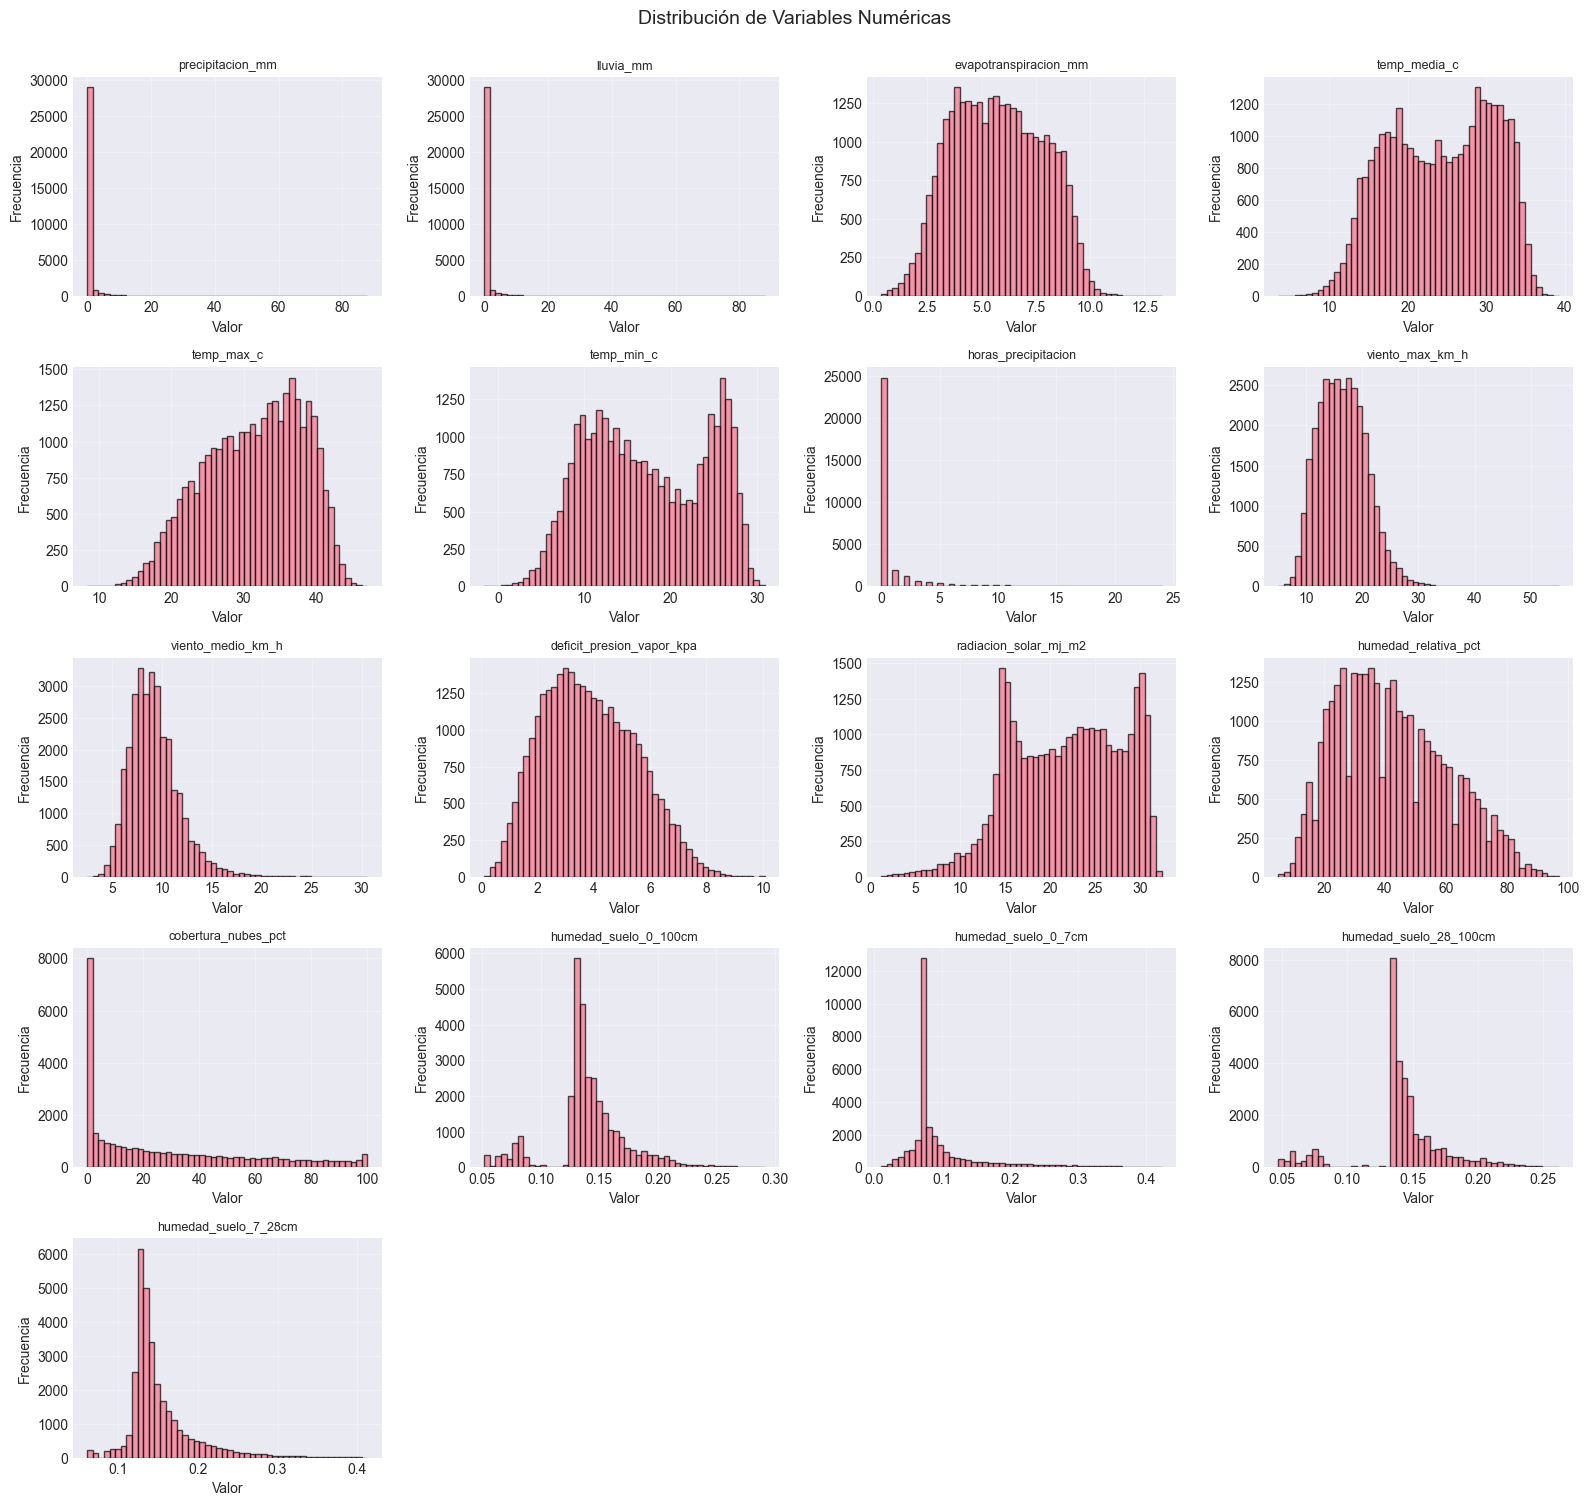

In [7]:
# Visualizar distribuciones de las variables
print("Generando gráficos de distribución...")

n_cols = 4
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].hist(df_analysis[col], bins=50, edgecolor='black', alpha=0.7)
    axes[i].set_title(col, fontsize=9)
    axes[i].set_xlabel('Valor')
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(True, alpha=0.3)

# Ocultar ejes sobrantes
for i in range(len(numeric_cols), len(axes)):
    axes[i].axis('off')

plt.suptitle('Distribución de Variables Numéricas', fontsize=14, y=1.001)
plt.tight_layout()
plt.show()

Calculando matriz de correlación...


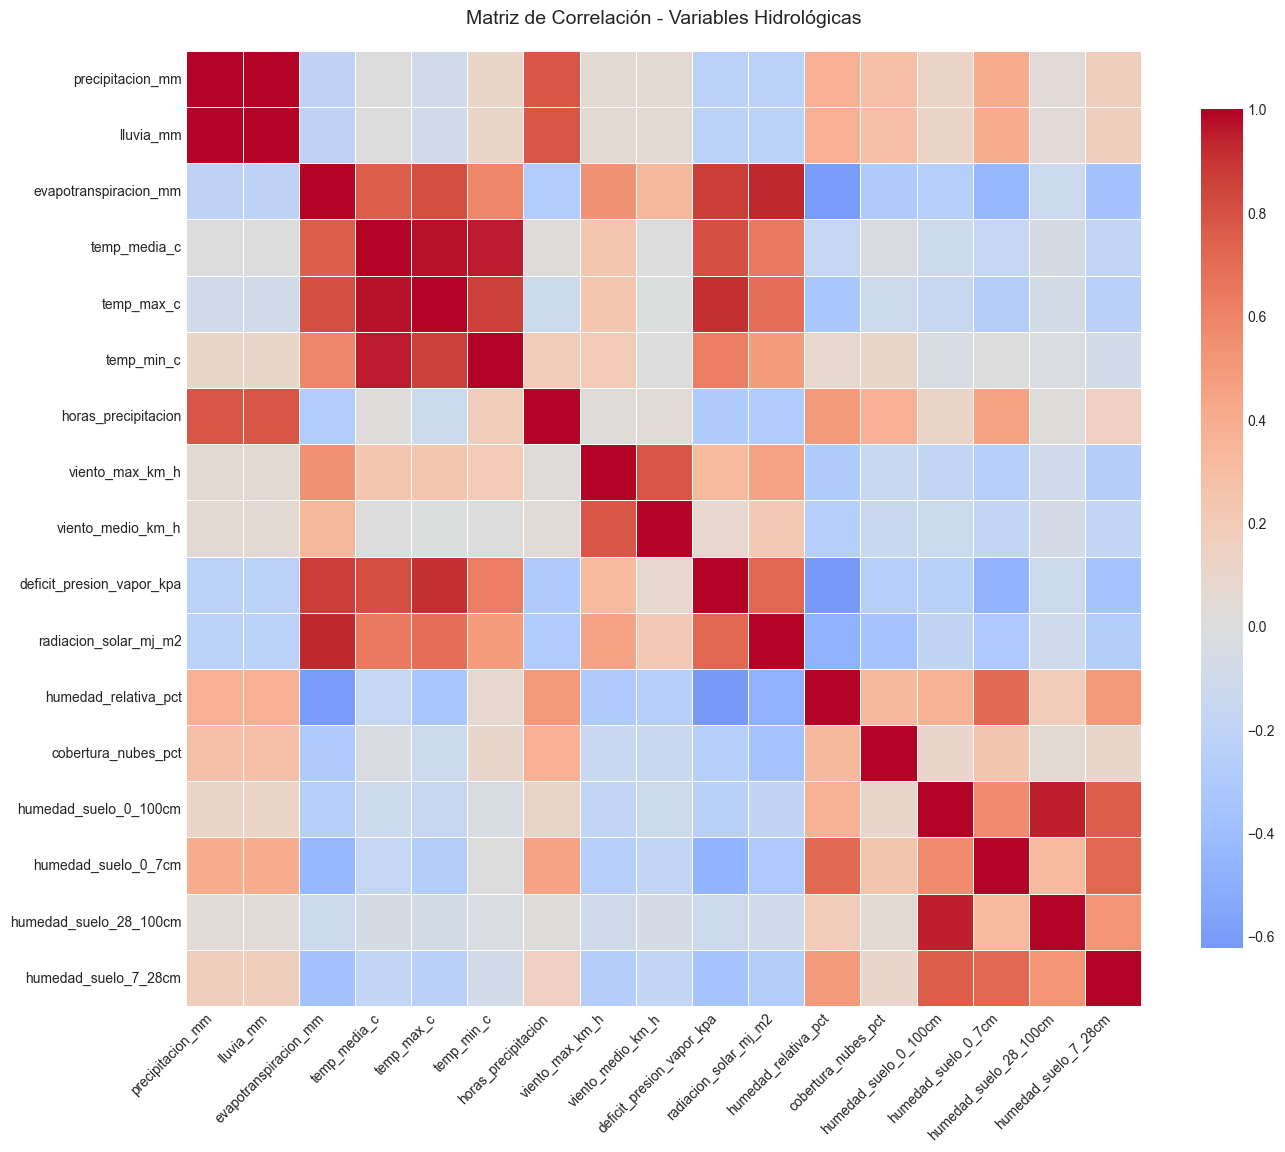


Correlaciones fuertes (|r| > 0.7):
               Variable 1                Variable 2  Correlación
         precipitacion_mm                 lluvia_mm     1.000000
             temp_media_c                temp_max_c     0.970115
             temp_media_c                temp_min_c     0.953787
    humedad_suelo_0_100cm    humedad_suelo_28_100cm     0.946899
    evapotranspiracion_mm     radiacion_solar_mj_m2     0.929546
               temp_max_c deficit_presion_vapor_kpa     0.906056
    evapotranspiracion_mm deficit_presion_vapor_kpa     0.871335
               temp_max_c                temp_min_c     0.861591
             temp_media_c deficit_presion_vapor_kpa     0.815577
    evapotranspiracion_mm                temp_max_c     0.812742
          viento_max_km_h         viento_medio_km_h     0.782727
         precipitacion_mm       horas_precipitacion     0.778748
                lluvia_mm       horas_precipitacion     0.778748
    humedad_suelo_0_100cm      humedad_suelo_7_28cm   

In [8]:
# Matriz de correlación
print("Calculando matriz de correlación...")

plt.figure(figsize=(14, 12))
correlation_matrix = df_analysis.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación - Variables Hidrológicas', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Identificar correlaciones fuertes
print("\nCorrelaciones fuertes (|r| > 0.7):")
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

high_corr_df = pd.DataFrame(high_corr, columns=['Variable 1', 'Variable 2', 'Correlación'])
high_corr_df = high_corr_df.sort_values(by='Correlación', ascending=False, key=abs)
print(high_corr_df.to_string(index=False))

In [9]:
# Estandarización de datos (requerida para PCA)
print("Estandarizando datos...")

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_analysis)
df_scaled_df = pd.DataFrame(df_scaled, columns=numeric_cols, index=df_analysis.index)

print(f"Datos estandarizados: {df_scaled_df.shape}")
print("\nEstadísticas después de estandarización (deberían tener media ~0 y std ~1):")
print(df_scaled_df.describe().loc[['mean', 'std']])

Estandarizando datos...
Datos estandarizados: (31047, 17)

Estadísticas después de estandarización (deberían tener media ~0 y std ~1):
      precipitacion_mm     lluvia_mm  evapotranspiracion_mm  temp_media_c  \
mean     -6.041913e-17 -6.041913e-17           1.830883e-16  3.295589e-17   
std       1.000016e+00  1.000016e+00           1.000016e+00  1.000016e+00   

        temp_max_c    temp_min_c  horas_precipitacion  viento_max_km_h  \
mean -1.647795e-16  2.490001e-16         6.041913e-17     5.803899e-16   
std   1.000016e+00  1.000016e+00         1.000016e+00     1.000016e+00   

      viento_medio_km_h  deficit_presion_vapor_kpa  radiacion_solar_mj_m2  \
mean      -6.115149e-16               3.570221e-17          -5.364487e-16   
std        1.000016e+00               1.000016e+00           1.000016e+00   

      humedad_relativa_pct  cobertura_nubes_pct  humedad_suelo_0_100cm  \
mean         -7.323531e-17        -1.830883e-17           7.909414e-16   
std           1.000016e+00    

## 4. Análisis de Componentes Principales (PCA)

In [10]:
# Aplicar PCA con todas las componentes
print("Aplicando PCA...")

pca_full = PCA()
pca_full.fit(df_scaled)

# Varianza explicada
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"\nNúmero total de componentes: {len(explained_variance)}")
print(f"Varianza explicada por las primeras 5 componentes:")
for i in range(min(5, len(explained_variance))):
    print(f"  PC{i+1}: {explained_variance[i]:.4f} ({explained_variance[i]*100:.2f}%)")
print(f"\nVarianza acumulada con 5 componentes: {cumulative_variance[4]:.4f} ({cumulative_variance[4]*100:.2f}%)")

Aplicando PCA...

Número total de componentes: 17
Varianza explicada por las primeras 5 componentes:
  PC1: 0.3686 (36.86%)
  PC2: 0.1977 (19.77%)
  PC3: 0.1426 (14.26%)
  PC4: 0.1041 (10.41%)
  PC5: 0.0511 (5.11%)

Varianza acumulada con 5 componentes: 0.8641 (86.41%)


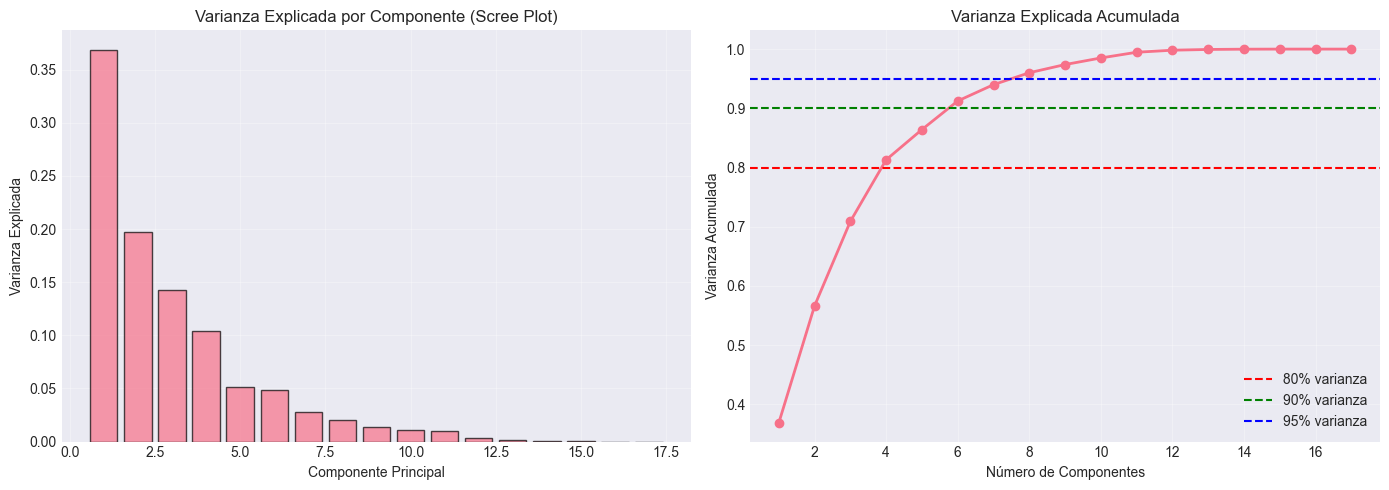


Componentes necesarias para:
  80% de varianza: 4 componentes
  90% de varianza: 6 componentes
  95% de varianza: 8 componentes


In [11]:
# Gráfico de varianza explicada (Scree Plot)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Varianza individual
axes[0].bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Componente Principal')
axes[0].set_ylabel('Varianza Explicada')
axes[0].set_title('Varianza Explicada por Componente (Scree Plot)')
axes[0].grid(True, alpha=0.3)

# Varianza acumulada
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', linewidth=2)
axes[1].axhline(y=0.80, color='r', linestyle='--', label='80% varianza')
axes[1].axhline(y=0.90, color='g', linestyle='--', label='90% varianza')
axes[1].axhline(y=0.95, color='b', linestyle='--', label='95% varianza')
axes[1].set_xlabel('Número de Componentes')
axes[1].set_ylabel('Varianza Acumulada')
axes[1].set_title('Varianza Explicada Acumulada')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Determinar número de componentes para 80%, 90%, 95% de varianza
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"\nComponentes necesarias para:")
print(f"  80% de varianza: {n_components_80} componentes")
print(f"  90% de varianza: {n_components_90} componentes")
print(f"  95% de varianza: {n_components_95} componentes")

In [12]:
# Aplicar PCA con número óptimo de componentes (usaremos 90% de varianza)
optimal_components = n_components_90
print(f"Aplicando PCA con {optimal_components} componentes (captura ~90% de varianza)...")

pca = PCA(n_components=optimal_components)
pca_data = pca.fit_transform(df_scaled)

# Crear DataFrame con componentes principales
pca_columns = [f'PC{i+1}' for i in range(optimal_components)]
df_pca = pd.DataFrame(pca_data, columns=pca_columns, index=df_analysis.index)

# Agregar fecha al DataFrame PCA
df_pca['fecha'] = df['fecha'].values

print(f"\nDimensiones del dataset PCA: {df_pca.shape}")
print(f"Varianza total explicada: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)")
df_pca.head()

Aplicando PCA con 6 componentes (captura ~90% de varianza)...

Dimensiones del dataset PCA: (31047, 7)
Varianza total explicada: 0.9124 (91.24%)


,PC1,PC2,PC3,PC4,PC5,PC6,fecha
0,-0.882759,-3.392617,-3.326344,-2.738297,-0.029510,0.310244,1940-01-01
1,-1.207362,-3.242882,-3.620093,-2.846199,1.038017,-0.234495,1940-01-02
2,-0.256140,-2.868078,-3.923194,-1.563887,1.249899,0.288423,1940-01-03
3,-1.383407,-3.145174,-3.517538,-3.017788,0.929365,0.166905,1940-01-04
4,-1.744732,-2.831507,-4.605331,-1.285598,2.369461,0.754803,1940-01-05



LOADINGS DE LAS PRIMERAS 3 COMPONENTES PRINCIPALES
                                PC1       PC2       PC3
precipitacion_mm          -0.395469  0.671993 -0.491175
lluvia_mm                 -0.395469  0.671993 -0.491175
evapotranspiracion_mm      0.926590  0.234251  0.072096
temp_media_c               0.713560  0.620802  0.166739
temp_max_c                 0.799691  0.499017  0.194173
temp_min_c                 0.533359  0.724585  0.124428
horas_precipitacion       -0.434062  0.649533 -0.453623
viento_max_km_h            0.469304  0.151151 -0.338296
viento_medio_km_h          0.267642  0.014046 -0.374482
deficit_presion_vapor_kpa  0.896828  0.238800  0.155073
radiacion_solar_mj_m2      0.817773  0.198168  0.148115
humedad_relativa_pct      -0.701686  0.388304  0.057848
cobertura_nubes_pct       -0.357531  0.289316 -0.173377
humedad_suelo_0_100cm     -0.475742  0.324775  0.700729
humedad_suelo_0_7cm       -0.659937  0.464980  0.233593
humedad_suelo_28_100cm    -0.311028  0.242593  0.686

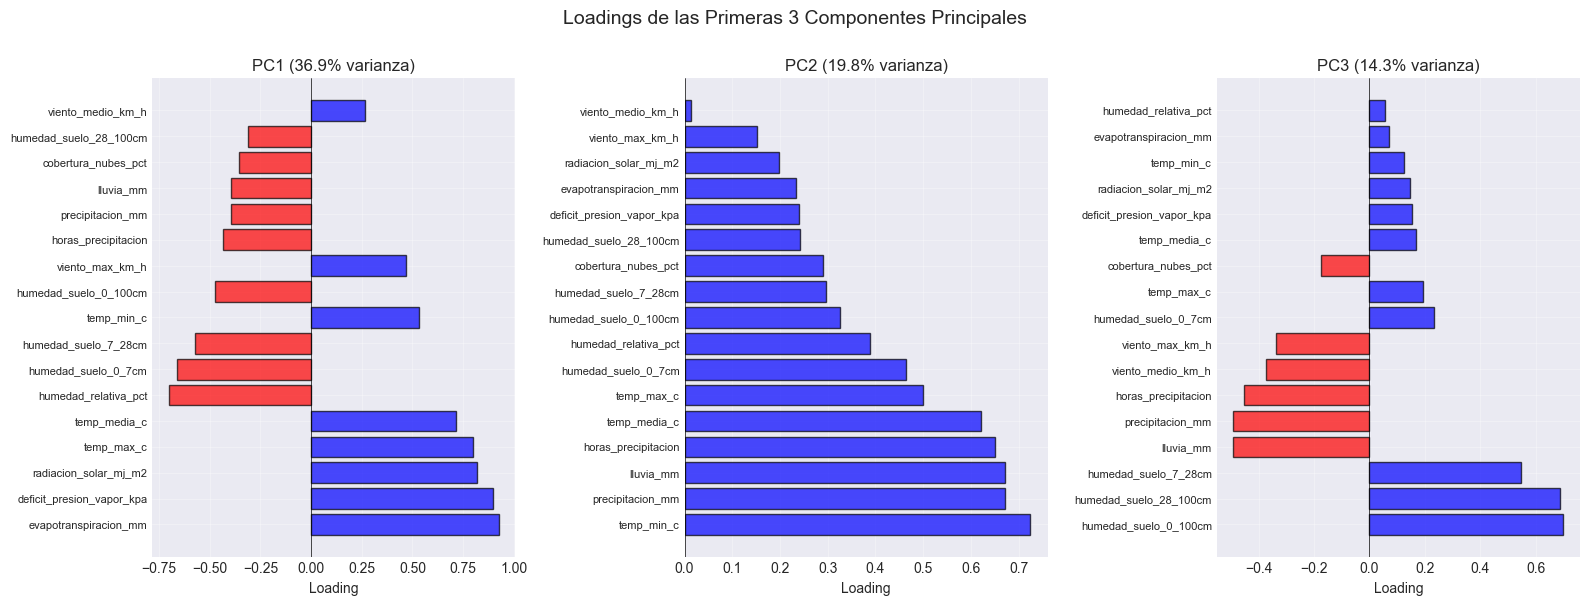

In [13]:
# Análisis de loadings (pesos de las variables en cada componente)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(
    loadings,
    columns=pca_columns,
    index=numeric_cols
)

print("\nLOADINGS DE LAS PRIMERAS 3 COMPONENTES PRINCIPALES")
print("=" * 80)
print(loadings_df.iloc[:, :3].to_string())

# Visualizar loadings de las primeras 3 componentes
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

for i in range(3):
    pc = f'PC{i+1}'
    loadings_sorted = loadings_df[pc].sort_values(key=abs, ascending=False)
    
    axes[i].barh(range(len(loadings_sorted)), loadings_sorted.values, 
                 color=['red' if x < 0 else 'blue' for x in loadings_sorted.values],
                 alpha=0.7, edgecolor='black')
    axes[i].set_yticks(range(len(loadings_sorted)))
    axes[i].set_yticklabels(loadings_sorted.index, fontsize=8)
    axes[i].set_xlabel('Loading')
    axes[i].set_title(f'{pc} ({pca.explained_variance_ratio_[i]*100:.1f}% varianza)')
    axes[i].axvline(x=0, color='black', linewidth=0.5)
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Loadings de las Primeras 3 Componentes Principales', fontsize=14, y=1.001)
plt.tight_layout()
plt.show()

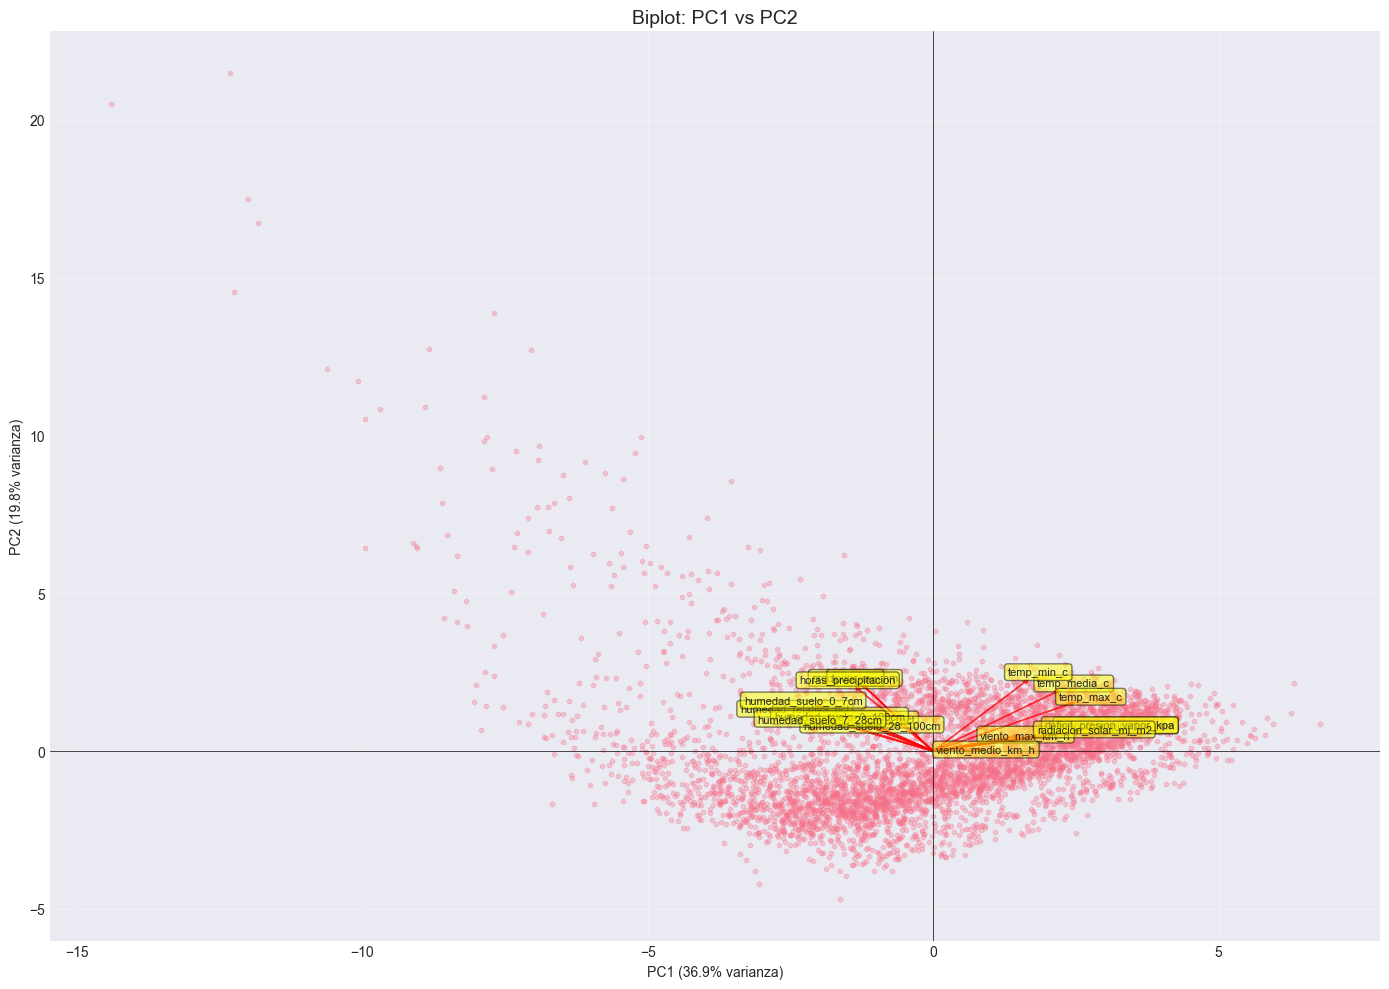

In [14]:
# Biplot: PC1 vs PC2
fig, ax = plt.subplots(figsize=(14, 10))

# Scatter plot de las observaciones (muestrear para mejor visualización)
sample_size = min(5000, len(df_pca))
sample_indices = np.random.choice(len(df_pca), sample_size, replace=False)
ax.scatter(df_pca.iloc[sample_indices]['PC1'], 
           df_pca.iloc[sample_indices]['PC2'], 
           alpha=0.3, s=10)

# Agregar vectores de loadings
scale_factor = 3  # Factor para visualizar mejor los vectores
for i, var in enumerate(numeric_cols):
    ax.arrow(0, 0, 
             loadings_df.loc[var, 'PC1'] * scale_factor, 
             loadings_df.loc[var, 'PC2'] * scale_factor,
             head_width=0.1, head_length=0.1, fc='red', ec='red', alpha=0.7)
    ax.text(loadings_df.loc[var, 'PC1'] * scale_factor * 1.15, 
            loadings_df.loc[var, 'PC2'] * scale_factor * 1.15,
            var, fontsize=8, ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% varianza)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% varianza)')
ax.set_title('Biplot: PC1 vs PC2', fontsize=14)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
plt.tight_layout()
plt.show()

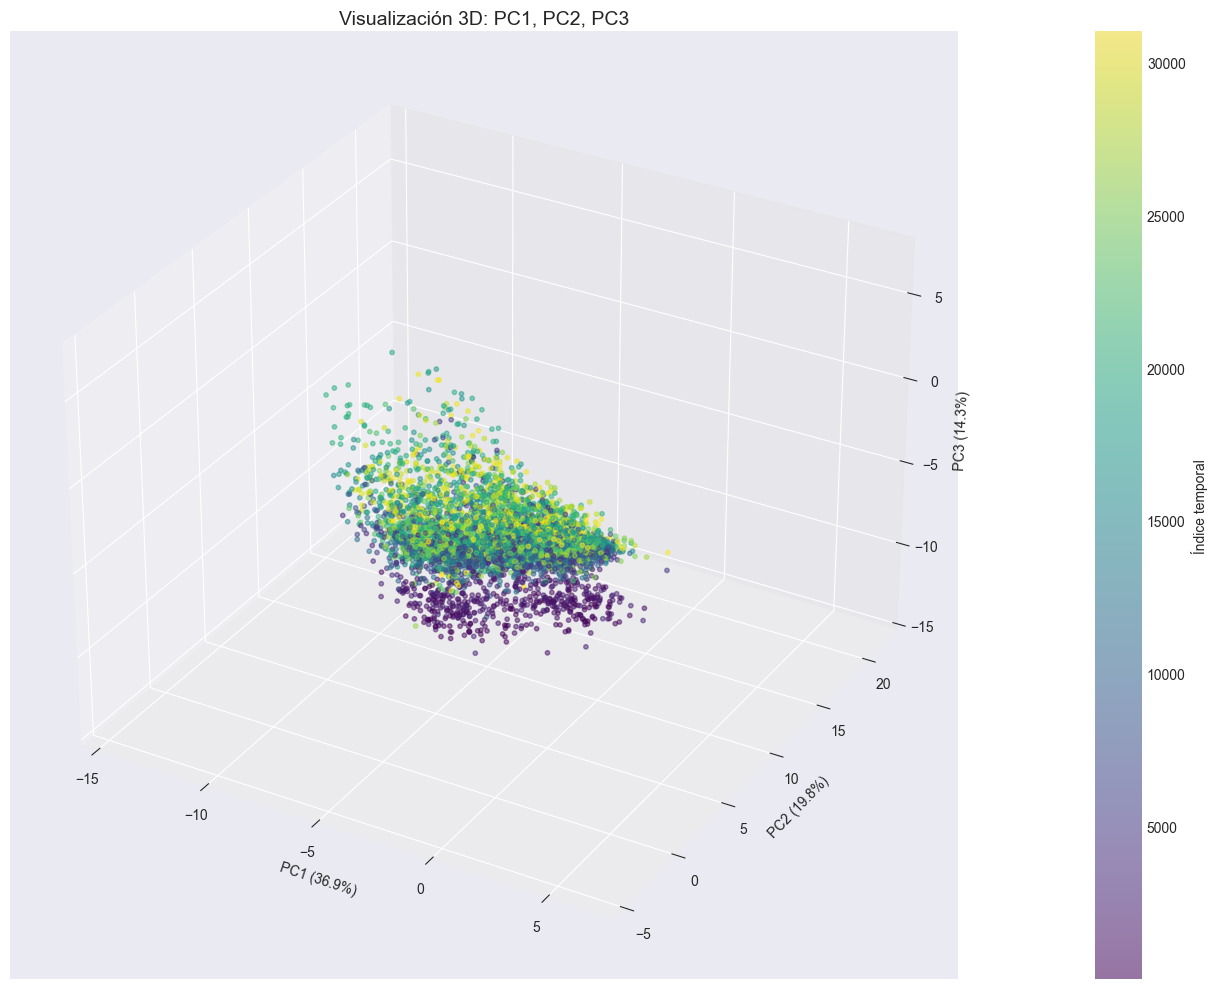

In [15]:
# Visualización de las primeras 3 componentes principales en 3D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Muestrear datos para mejor visualización
sample_size = min(5000, len(df_pca))
sample_indices = np.random.choice(len(df_pca), sample_size, replace=False)

scatter = ax.scatter(df_pca.iloc[sample_indices]['PC1'],
                     df_pca.iloc[sample_indices]['PC2'],
                     df_pca.iloc[sample_indices]['PC3'],
                     c=df_pca.iloc[sample_indices].index,
                     cmap='viridis', alpha=0.5, s=10)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
ax.set_title('Visualización 3D: PC1, PC2, PC3', fontsize=14)

plt.colorbar(scatter, label='Índice temporal', pad=0.1)
plt.tight_layout()
plt.show()

## 5. Detección de Outliers

### 5.1. Método 1: Z-Score (Distancia de Mahalanobis simplificada)

In [16]:
# Detección de outliers usando Z-score en datos estandarizados
print("Método 1: Detección de Outliers usando Z-Score")
print("=" * 80)

# Calcular Z-score para cada variable
z_scores = np.abs(stats.zscore(df_analysis))

# Umbral: puntos con Z-score > 3 en cualquier variable
threshold = 3
outliers_zscore = (z_scores > threshold).any(axis=1)

print(f"Umbral Z-score: {threshold}")
print(f"Outliers detectados: {outliers_zscore.sum()} ({outliers_zscore.sum()/len(df)*100:.2f}%)")
print(f"Observaciones normales: {(~outliers_zscore).sum()} ({(~outliers_zscore).sum()/len(df)*100:.2f}%)")

Método 1: Detección de Outliers usando Z-Score
Umbral Z-score: 3
Outliers detectados: 2239 (7.21%)
Observaciones normales: 28808 (92.79%)


### 5.2. Método 2: Isolation Forest

In [17]:
# Detección de outliers usando Isolation Forest
print("Método 2: Detección de Outliers usando Isolation Forest")
print("=" * 80)

# Configurar Isolation Forest
iso_forest = IsolationForest(
    contamination=0.05,  # Esperamos ~5% de outliers
    random_state=42,
    n_estimators=100
)

# Aplicar en datos estandarizados
outliers_iso = iso_forest.fit_predict(df_scaled)
outliers_iso_bool = outliers_iso == -1  # -1 indica outlier

# Scores de anomalía (más negativo = más anómalo)
anomaly_scores_iso = iso_forest.score_samples(df_scaled)

print(f"Outliers detectados: {outliers_iso_bool.sum()} ({outliers_iso_bool.sum()/len(df)*100:.2f}%)")
print(f"Observaciones normales: {(~outliers_iso_bool).sum()} ({(~outliers_iso_bool).sum()/len(df)*100:.2f}%)")
print(f"\nScore de anomalía (más negativo = más anómalo):")
print(f"  Mínimo: {anomaly_scores_iso.min():.4f}")
print(f"  Máximo: {anomaly_scores_iso.max():.4f}")
print(f"  Media: {anomaly_scores_iso.mean():.4f}")

Método 2: Detección de Outliers usando Isolation Forest
Outliers detectados: 1553 (5.00%)
Observaciones normales: 29494 (95.00%)

Score de anomalía (más negativo = más anómalo):
  Mínimo: -0.7559
  Máximo: -0.3631
  Media: -0.4371


### 5.3. Método 3: Local Outlier Factor (LOF)

In [18]:
# Detección de outliers usando Local Outlier Factor (LOF)
print("Método 3: Detección de Outliers usando Local Outlier Factor (LOF)")
print("=" * 80)

# Configurar LOF
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.05  # Esperamos ~5% de outliers
)

# Aplicar en datos estandarizados
outliers_lof = lof.fit_predict(df_scaled)
outliers_lof_bool = outliers_lof == -1  # -1 indica outlier

# Scores negativos de LOF (más negativo = más anómalo)
lof_scores = lof.negative_outlier_factor_

print(f"Outliers detectados: {outliers_lof_bool.sum()} ({outliers_lof_bool.sum()/len(df)*100:.2f}%)")
print(f"Observaciones normales: {(~outliers_lof_bool).sum()} ({(~outliers_lof_bool).sum()/len(df)*100:.2f}%)")
print(f"\nLOF Score (más negativo = más anómalo):")
print(f"  Mínimo: {lof_scores.min():.4f}")
print(f"  Máximo: {lof_scores.max():.4f}")
print(f"  Media: {lof_scores.mean():.4f}")

Método 3: Detección de Outliers usando Local Outlier Factor (LOF)
Outliers detectados: 1553 (5.00%)
Observaciones normales: 29494 (95.00%)

LOF Score (más negativo = más anómalo):
  Mínimo: -2.1412
  Máximo: -0.9520
  Media: -1.0730


### 5.4. Método 4: Elliptic Envelope (Asumiendo distribución Gaussiana multivariada)

In [19]:
# Detección de outliers usando Elliptic Envelope
print("Método 4: Detección de Outliers usando Elliptic Envelope")
print("=" * 80)

# Configurar Elliptic Envelope
elliptic = EllipticEnvelope(
    contamination=0.05,  # Esperamos ~5% de outliers
    random_state=42
)

# Aplicar en datos estandarizados
outliers_elliptic = elliptic.fit_predict(df_scaled)
outliers_elliptic_bool = outliers_elliptic == -1  # -1 indica outlier

# Scores de Mahalanobis distance
mahalanobis_scores = elliptic.score_samples(df_scaled)

print(f"Outliers detectados: {outliers_elliptic_bool.sum()} ({outliers_elliptic_bool.sum()/len(df)*100:.2f}%)")
print(f"Observaciones normales: {(~outliers_elliptic_bool).sum()} ({(~outliers_elliptic_bool).sum()/len(df)*100:.2f}%)")
print(f"\nMahalanobis Distance Score (más negativo = más anómalo):")
print(f"  Mínimo: {mahalanobis_scores.min():.4f}")
print(f"  Máximo: {mahalanobis_scores.max():.4f}")
print(f"  Media: {mahalanobis_scores.mean():.4f}")

Método 4: Detección de Outliers usando Elliptic Envelope
Outliers detectados: 1553 (5.00%)
Observaciones normales: 29494 (95.00%)

Mahalanobis Distance Score (más negativo = más anómalo):
  Mínimo: -28640599.2320
  Máximo: -1.9695
  Media: -23932.7330


### 5.5. Método 5: Outliers en el espacio PCA

In [20]:
# Detección de outliers en el espacio PCA usando distancia euclidiana
print("Método 5: Detección de Outliers en el Espacio PCA")
print("=" * 80)

# Calcular distancia euclidiana desde el origen en el espacio PCA
pca_distances = np.sqrt(np.sum(pca_data**2, axis=1))

# Usar percentil 95 como umbral
threshold_pca = np.percentile(pca_distances, 95)
outliers_pca_bool = pca_distances > threshold_pca

print(f"Umbral (percentil 95): {threshold_pca:.4f}")
print(f"Outliers detectados: {outliers_pca_bool.sum()} ({outliers_pca_bool.sum()/len(df)*100:.2f}%)")
print(f"Observaciones normales: {(~outliers_pca_bool).sum()} ({(~outliers_pca_bool).sum()/len(df)*100:.2f}%)")
print(f"\nDistancia PCA:")
print(f"  Mínima: {pca_distances.min():.4f}")
print(f"  Máxima: {pca_distances.max():.4f}")
print(f"  Media: {pca_distances.mean():.4f}")
print(f"  Mediana: {np.median(pca_distances):.4f}")

Método 5: Detección de Outliers en el Espacio PCA
Umbral (percentil 95): 6.1112
Outliers detectados: 1553 (5.00%)
Observaciones normales: 29494 (95.00%)

Distancia PCA:
  Mínima: 0.6316
  Máxima: 45.3214
  Media: 3.5128
  Mediana: 3.2211


### 5.6. Comparación de Métodos

In [21]:
# Crear DataFrame con todos los resultados
outliers_comparison = pd.DataFrame({
    'fecha': df['fecha'],
    'Z-Score': outliers_zscore,
    'Isolation_Forest': outliers_iso_bool,
    'LOF': outliers_lof_bool,
    'Elliptic_Envelope': outliers_elliptic_bool,
    'PCA_Distance': outliers_pca_bool
})

# Agregar columna de consenso (outlier si al menos 3 métodos lo detectan)
outliers_comparison['Consenso_3+'] = (
    outliers_comparison[['Z-Score', 'Isolation_Forest', 'LOF', 'Elliptic_Envelope', 'PCA_Distance']].sum(axis=1) >= 3
)

print("\nCOMPARACIÓN DE MÉTODOS DE DETECCIÓN DE OUTLIERS")
print("=" * 80)
print("\nNúmero de outliers detectados por cada método:")
for col in ['Z-Score', 'Isolation_Forest', 'LOF', 'Elliptic_Envelope', 'PCA_Distance', 'Consenso_3+']:
    count = outliers_comparison[col].sum()
    pct = count / len(df) * 100
    print(f"  {col:25s}: {count:6d} ({pct:5.2f}%)")


COMPARACIÓN DE MÉTODOS DE DETECCIÓN DE OUTLIERS

Número de outliers detectados por cada método:
  Z-Score                  :   2239 ( 7.21%)
  Isolation_Forest         :   1553 ( 5.00%)
  LOF                      :   1553 ( 5.00%)
  Elliptic_Envelope        :   1553 ( 5.00%)
  PCA_Distance             :   1553 ( 5.00%)
  Consenso_3+              :   1288 ( 4.15%)


## 6. Visualización de Outliers

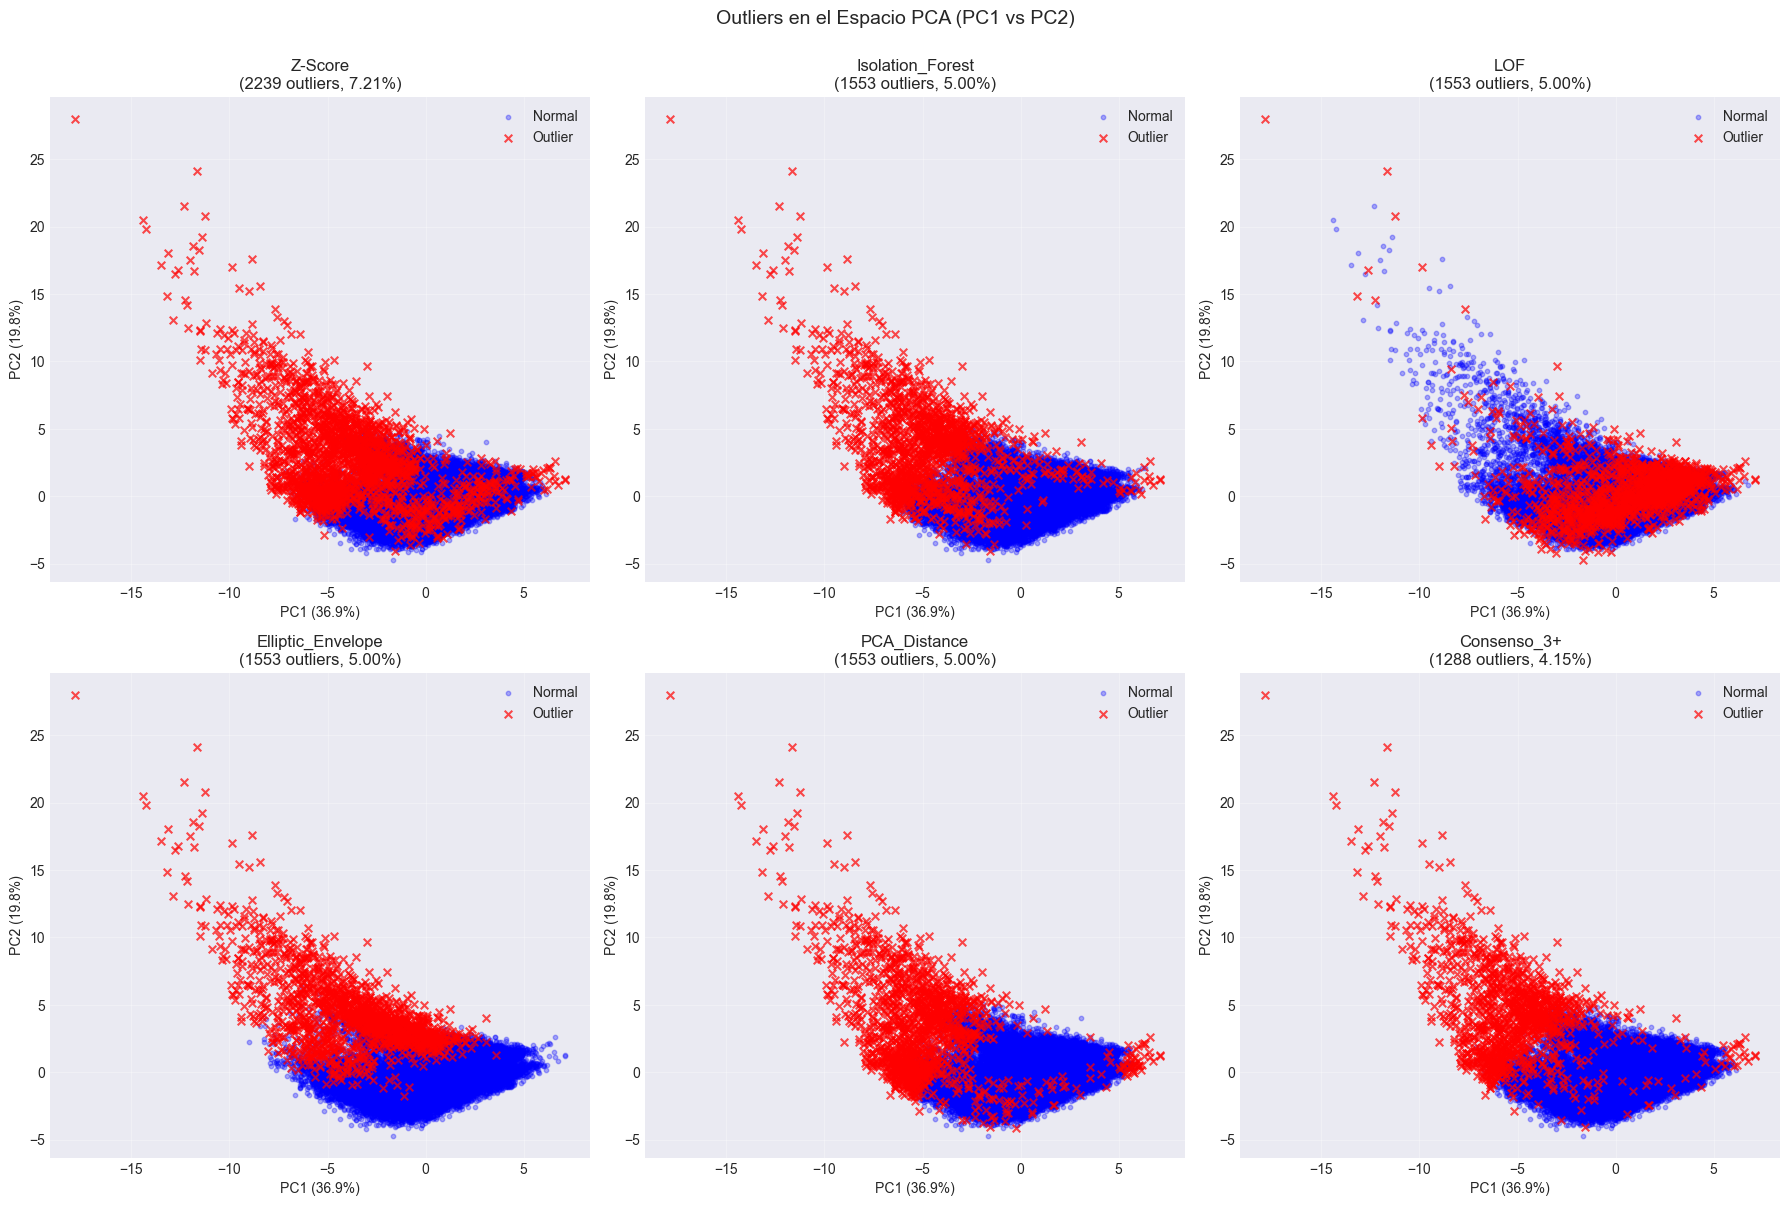

In [23]:
# Visualizar outliers en el espacio PCA (PC1 vs PC2)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

outlier_methods = [
    ('Z-Score', outliers_zscore),
    ('Isolation_Forest', outliers_iso_bool),
    ('LOF', outliers_lof_bool),
    ('Elliptic_Envelope', outliers_elliptic_bool),
    ('PCA_Distance', outliers_pca_bool),
    ('Consenso_3+', outliers_comparison['Consenso_3+'])
]

for idx, (method_name, outlier_mask) in enumerate(outlier_methods):
    # Plotear normales
    axes[idx].scatter(df_pca.loc[~outlier_mask, 'PC1'], 
                     df_pca.loc[~outlier_mask, 'PC2'],
                     c='blue', s=10, alpha=0.3, label='Normal')
    # Plotear outliers
    axes[idx].scatter(df_pca.loc[outlier_mask, 'PC1'], 
                     df_pca.loc[outlier_mask, 'PC2'],
                     c='red', s=30, alpha=0.7, marker='x', label='Outlier')
    
    axes[idx].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    axes[idx].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    axes[idx].set_title(f'{method_name}\n({outlier_mask.sum()} outliers, {outlier_mask.sum()/len(df)*100:.2f}%)')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Outliers en el Espacio PCA (PC1 vs PC2)', fontsize=14, y=1.001)
plt.tight_layout()
plt.show()

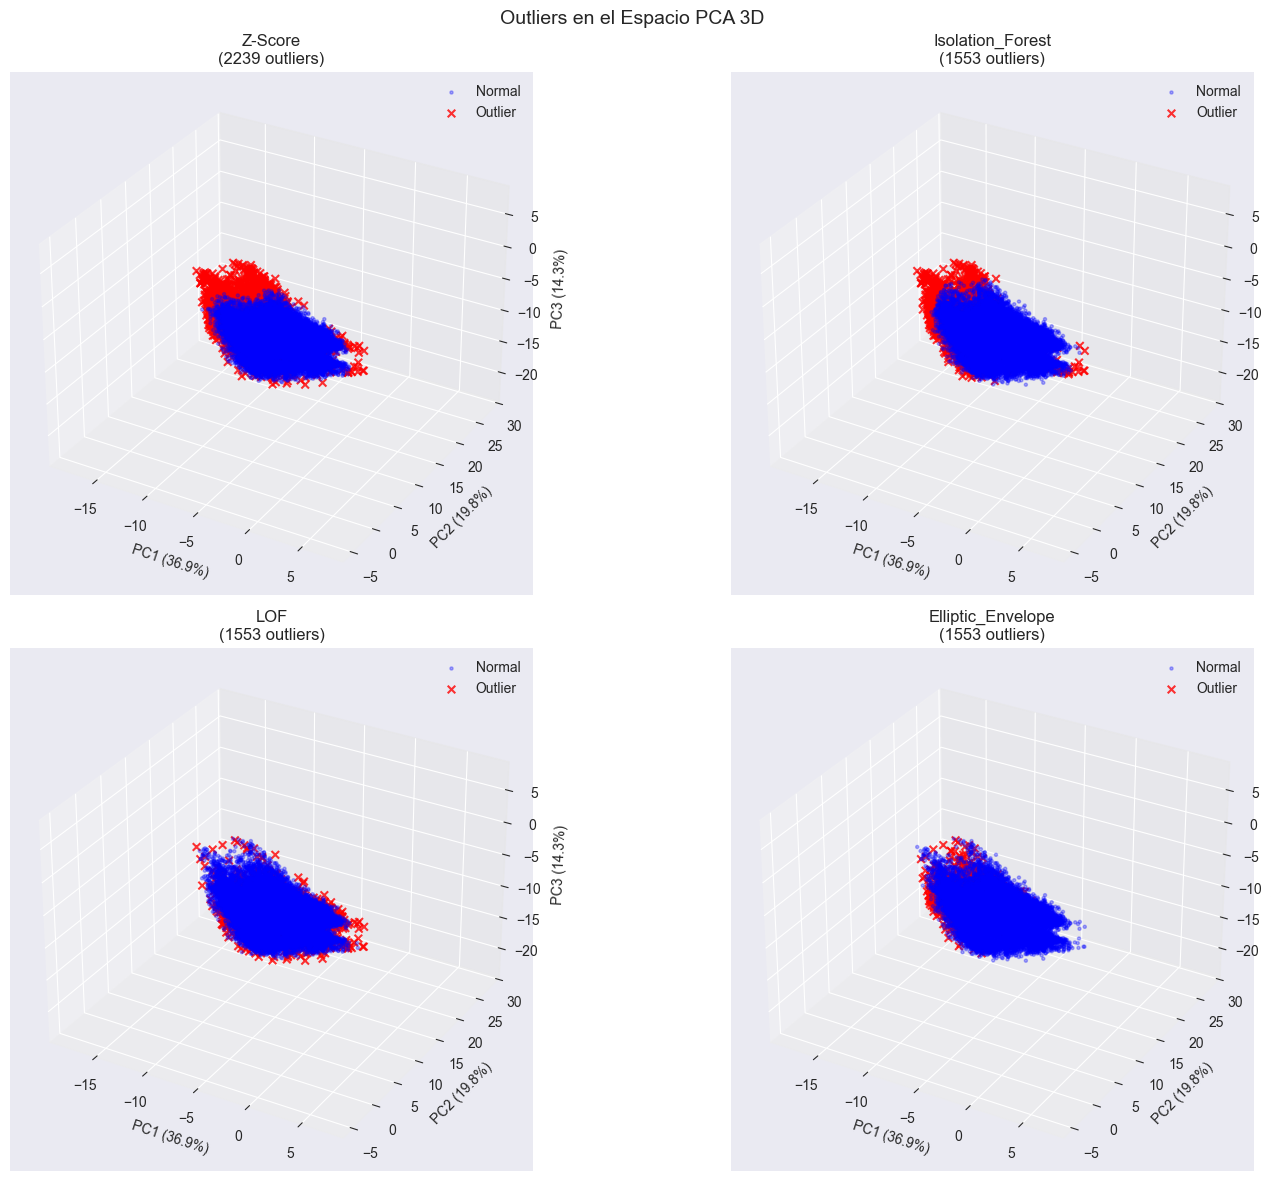

In [24]:
# Visualización 3D de outliers en espacio PCA
fig = plt.figure(figsize=(16, 12))

for idx, (method_name, outlier_mask) in enumerate(outlier_methods[:4], 1):
    ax = fig.add_subplot(2, 2, idx, projection='3d')
    
    # Normales
    ax.scatter(df_pca.loc[~outlier_mask, 'PC1'],
               df_pca.loc[~outlier_mask, 'PC2'],
               df_pca.loc[~outlier_mask, 'PC3'],
               c='blue', s=5, alpha=0.3, label='Normal')
    
    # Outliers
    ax.scatter(df_pca.loc[outlier_mask, 'PC1'],
               df_pca.loc[outlier_mask, 'PC2'],
               df_pca.loc[outlier_mask, 'PC3'],
               c='red', s=30, alpha=0.8, marker='x', label='Outlier')
    
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
    ax.set_title(f'{method_name}\n({outlier_mask.sum()} outliers)')
    ax.legend()

plt.suptitle('Outliers en el Espacio PCA 3D', fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

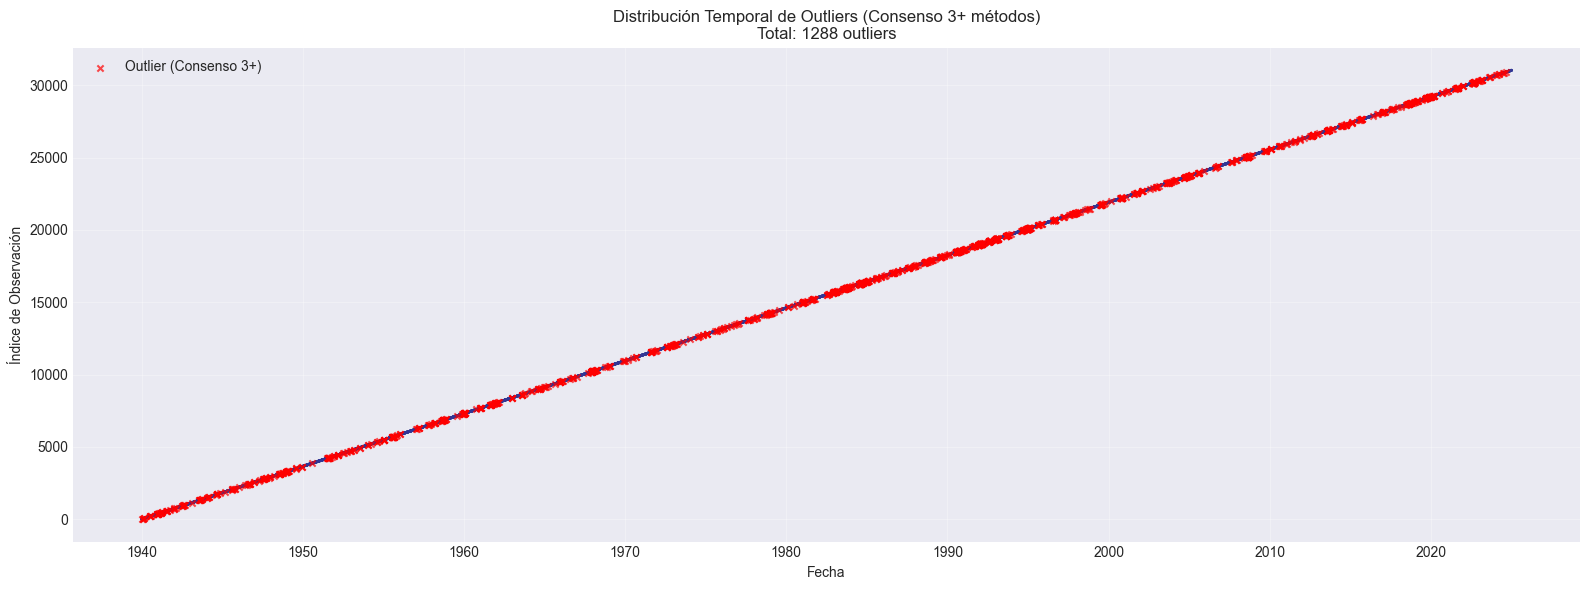


Primeros 10 outliers detectados por consenso:
         fecha
4   1940-01-05
31  1940-02-01
32  1940-02-02
52  1940-02-22
56  1940-02-26
184 1940-07-03
185 1940-07-04
186 1940-07-05
203 1940-07-22
340 1940-12-06


In [25]:
# Visualización temporal de outliers (usando consenso)
fig, ax = plt.subplots(figsize=(16, 6))

# Plotear todas las observaciones
ax.scatter(outliers_comparison['fecha'], 
           range(len(outliers_comparison)),
           c=outliers_comparison['Consenso_3+'].astype(int),
           cmap='RdYlBu_r', s=1, alpha=0.5)

# Marcar outliers por consenso
outlier_dates = outliers_comparison[outliers_comparison['Consenso_3+']]['fecha']
outlier_indices = outliers_comparison[outliers_comparison['Consenso_3+']].index

ax.scatter(outlier_dates, outlier_indices, 
           c='red', s=20, alpha=0.7, marker='x', label='Outlier (Consenso 3+)')

ax.set_xlabel('Fecha')
ax.set_ylabel('Índice de Observación')
ax.set_title(f'Distribución Temporal de Outliers (Consenso 3+ métodos)\nTotal: {len(outlier_dates)} outliers')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nPrimeros 10 outliers detectados por consenso:")
print(outliers_comparison[outliers_comparison['Consenso_3+']][['fecha']].head(10).to_string(index=True))

In [26]:
# Análisis de las variables originales en outliers detectados por consenso
outlier_indices_consensus = outliers_comparison[outliers_comparison['Consenso_3+']].index
normal_indices_consensus = outliers_comparison[~outliers_comparison['Consenso_3+']].index

# Comparar estadísticas entre outliers y normales
print("\nCOMPARACIÓN DE VARIABLES: OUTLIERS vs NORMALES (Consenso 3+)")
print("=" * 80)

comparison_stats = pd.DataFrame({
    'Normal_Media': df_analysis.loc[normal_indices_consensus].mean(),
    'Outlier_Media': df_analysis.loc[outlier_indices_consensus].mean(),
    'Normal_Std': df_analysis.loc[normal_indices_consensus].std(),
    'Outlier_Std': df_analysis.loc[outlier_indices_consensus].std(),
    'Diferencia_Media': df_analysis.loc[outlier_indices_consensus].mean() - df_analysis.loc[normal_indices_consensus].mean()
})

comparison_stats['Diferencia_%'] = (comparison_stats['Diferencia_Media'] / comparison_stats['Normal_Media']) * 100

print(comparison_stats.to_string())


COMPARACIÓN DE VARIABLES: OUTLIERS vs NORMALES (Consenso 3+)
                           Normal_Media  Outlier_Media  Normal_Std  Outlier_Std  Diferencia_Media  Diferencia_%
precipitacion_mm               0.201529       8.950932    0.756558     9.591747          8.749403   4341.511610
lluvia_mm                      0.201529       8.950932    0.756558     9.591747          8.749403   4341.511610
evapotranspiracion_mm          5.837541       3.175334    1.997081     1.827436         -2.662207    -45.604941
temp_media_c                  24.310363      21.420264    6.628416     6.747481         -2.890099    -11.888343
temp_max_c                    31.690020      25.718323    6.594498     7.257102         -5.971697    -18.844093
temp_min_c                    17.191223      18.004736    6.824641     6.711494          0.813513      4.732143
horas_precipitacion            0.472160       8.954969    1.367740     5.920569          8.482809   1796.597543
viento_max_km_h               16.400867   

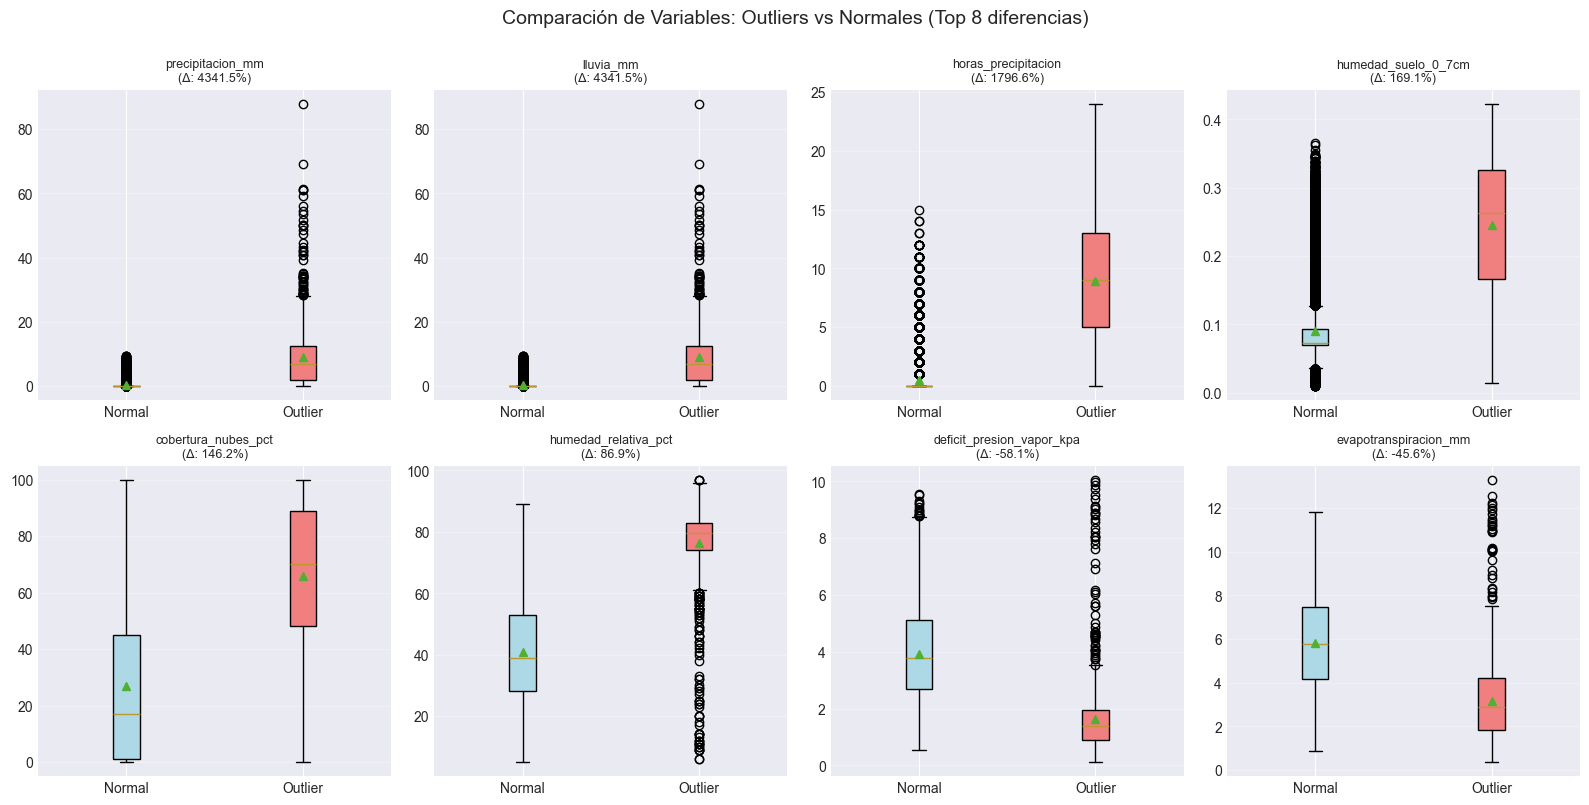

In [27]:
# Boxplots comparativos para variables seleccionadas
# Seleccionar variables con mayor diferencia
top_diff_vars = comparison_stats.sort_values(by='Diferencia_%', key=abs, ascending=False).head(8).index.tolist()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, var in enumerate(top_diff_vars):
    data_to_plot = [
        df_analysis.loc[normal_indices_consensus, var],
        df_analysis.loc[outlier_indices_consensus, var]
    ]
    
    bp = axes[idx].boxplot(data_to_plot, labels=['Normal', 'Outlier'],
                           patch_artist=True, showmeans=True)
    
    # Colorear cajas
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    axes[idx].set_title(f'{var}\n(Δ: {comparison_stats.loc[var, "Diferencia_%"]:.1f}%)', fontsize=9)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Comparación de Variables: Outliers vs Normales (Top 8 diferencias)', fontsize=14, y=1.001)
plt.tight_layout()
plt.show()

## 7. Análisis de Outliers Específicos

In [28]:
# Examinar los outliers más extremos
print("\nOUTLIERS MÁS EXTREMOS (Top 10)")
print("=" * 80)

# Usar distancia PCA como medida de extremidad
df_with_pca_dist = df.copy()
df_with_pca_dist['PCA_Distance'] = pca_distances
df_with_pca_dist['Is_Outlier_Consensus'] = outliers_comparison['Consenso_3+'].values

# Top 10 outliers más extremos
top_outliers = df_with_pca_dist[df_with_pca_dist['Is_Outlier_Consensus']].nlargest(10, 'PCA_Distance')

print("\nTop 10 outliers por distancia PCA:")
print(top_outliers[['fecha', 'PCA_Distance', 'precipitacion_mm', 'temp_media_c', 
                     'evapotranspiracion_mm', 'humedad_relativa_pct']].to_string(index=True))


OUTLIERS MÁS EXTREMOS (Top 10)

Top 10 outliers por distancia PCA:
           fecha  PCA_Distance  precipitacion_mm  temp_media_c  evapotranspiracion_mm  humedad_relativa_pct
20062 1994-12-05     45.321408              87.9          15.6                   0.43                    93
28009 2016-09-07     36.063671              69.2          25.4                   3.34                    86
22553 2001-09-30     33.238845              61.1          22.8                   1.57                    83
15683 1982-12-09     32.413869              59.2          16.6                   0.99                    93
6839  1958-09-22     31.646835              60.9          25.2                   3.14                    82
18971 1991-12-10     31.085565              61.2          18.0                   1.05                    85
22210 2000-10-22     30.671448              55.9          17.6                   1.53                    91
28774 2018-10-12     29.007158              53.4          20.6      


ANÁLISIS DETALLADO DEL OUTLIER MÁS EXTREMO
Fecha: 1994-12-05 00:00:00
Índice: 20062
Distancia PCA: 45.3214

Valores de las variables:
precipitacion_mm              87.900
lluvia_mm                     87.900
evapotranspiracion_mm          0.430
temp_media_c                  15.600
temp_max_c                    18.000
temp_min_c                    13.900
horas_precipitacion           23.000
viento_max_km_h               34.500
viento_medio_km_h             16.900
deficit_presion_vapor_kpa      0.670
radiacion_solar_mj_m2          1.240
humedad_relativa_pct          93.000
cobertura_nubes_pct          100.000
humedad_suelo_0_100cm          0.208
humedad_suelo_0_7cm            0.338
humedad_suelo_28_100cm         0.174
humedad_suelo_7_28cm           0.280

Z-Scores de las variables:
precipitacion_mm         32.090702
lluvia_mm                32.090702
horas_precipitacion       8.973122
viento_max_km_h           4.206469
humedad_suelo_0_7cm       4.029411
radiacion_solar_mj_m2    -3.39854

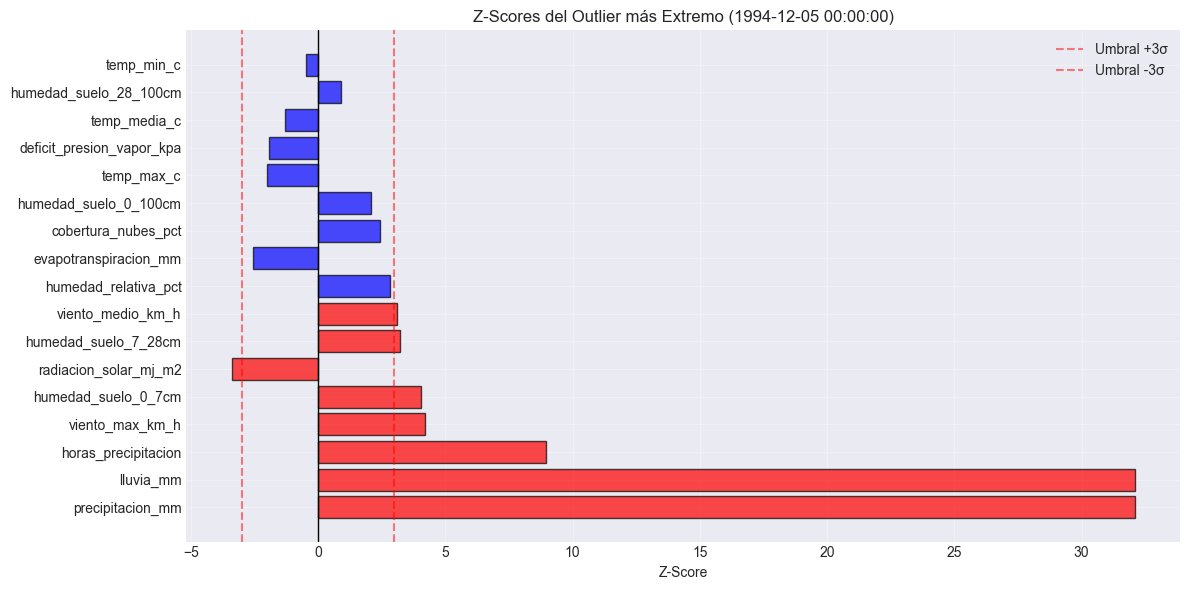

In [29]:
# Analizar un outlier específico en detalle
if len(top_outliers) > 0:
    # Seleccionar el outlier más extremo
    extreme_outlier_idx = top_outliers.index[0]
    extreme_outlier_date = top_outliers.iloc[0]['fecha']
    
    print(f"\nANÁLISIS DETALLADO DEL OUTLIER MÁS EXTREMO")
    print("=" * 80)
    print(f"Fecha: {extreme_outlier_date}")
    print(f"Índice: {extreme_outlier_idx}")
    print(f"Distancia PCA: {pca_distances[extreme_outlier_idx]:.4f}")
    
    print("\nValores de las variables:")
    print(df_analysis.loc[extreme_outlier_idx].to_string())
    
    print("\nZ-Scores de las variables:")
    z_scores_outlier = (df_analysis.loc[extreme_outlier_idx] - df_analysis.mean()) / df_analysis.std()
    z_scores_sorted = z_scores_outlier.sort_values(key=abs, ascending=False)
    print(z_scores_sorted.head(10).to_string())
    
    # Visualizar Z-scores
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(z_scores_sorted)), z_scores_sorted.values,
             color=['red' if abs(x) > 3 else 'blue' for x in z_scores_sorted.values],
             alpha=0.7, edgecolor='black')
    plt.yticks(range(len(z_scores_sorted)), z_scores_sorted.index)
    plt.xlabel('Z-Score')
    plt.title(f'Z-Scores del Outlier más Extremo ({extreme_outlier_date})')
    plt.axvline(x=3, color='red', linestyle='--', alpha=0.5, label='Umbral +3σ')
    plt.axvline(x=-3, color='red', linestyle='--', alpha=0.5, label='Umbral -3σ')
    plt.axvline(x=0, color='black', linewidth=1)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [30]:
# Guardar resultados para análisis posterior
print("Guardando resultados...")

# DataFrame con componentes principales
df_pca_full = df_pca.copy()
df_pca_full.to_csv('../data/processed/pca_components.csv', index=False)
print("  ✓ Componentes PCA guardadas en: data/processed/pca_components.csv")

# DataFrame con detección de outliers
outliers_comparison.to_csv('../data/processed/outliers_detection.csv', index=False)
print("  ✓ Detección de outliers guardada en: data/processed/outliers_detection.csv")

# Guardar loadings
loadings_df.to_csv('../data/processed/pca_loadings.csv', index=True)
print("  ✓ Loadings PCA guardados en: data/processed/pca_loadings.csv")

print("\n¡Análisis completado exitosamente!")

Guardando resultados...
  ✓ Componentes PCA guardadas en: data/processed/pca_components.csv
  ✓ Detección de outliers guardada en: data/processed/outliers_detection.csv
  ✓ Loadings PCA guardados en: data/processed/pca_loadings.csv

¡Análisis completado exitosamente!


In [31]:
# Resumen final
print("\n" + "=" * 80)
print("RESUMEN FINAL DEL ANÁLISIS")
print("=" * 80)
print(f"\nDataset analizado: datos_hidrologicos_completos.csv")
print(f"Periodo: {df['fecha'].min()} a {df['fecha'].max()}")
print(f"Total de observaciones: {len(df):,}")
print(f"Variables analizadas: {len(numeric_cols)}")
print(f"\nPCA:")
print(f"  - Componentes óptimas (90% varianza): {optimal_components}")
print(f"  - Reducción dimensional: {len(numeric_cols)} → {optimal_components} ({(1-optimal_components/len(numeric_cols))*100:.1f}% reducción)")
print(f"\nOutliers (Consenso 3+ métodos):")
print(f"  - Total detectados: {outliers_comparison['Consenso_3+'].sum():,} ({outliers_comparison['Consenso_3+'].sum()/len(df)*100:.2f}%)")
print(f"  - Observaciones normales: {(~outliers_comparison['Consenso_3+']).sum():,} ({(~outliers_comparison['Consenso_3+']).sum()/len(df)*100:.2f}%)")
print(f"\nArchivos generados:")
print(f"  - pca_components.csv")
print(f"  - outliers_detection.csv")
print(f"  - pca_loadings.csv")
print("\n" + "=" * 80)


RESUMEN FINAL DEL ANÁLISIS

Dataset analizado: datos_hidrologicos_completos.csv
Periodo: 1940-01-01 00:00:00 a 2024-12-31 00:00:00
Total de observaciones: 31,047
Variables analizadas: 17

PCA:
  - Componentes óptimas (90% varianza): 6
  - Reducción dimensional: 17 → 6 (64.7% reducción)

Outliers (Consenso 3+ métodos):
  - Total detectados: 1,288 (4.15%)
  - Observaciones normales: 29,759 (95.85%)

Archivos generados:
  - pca_components.csv
  - outliers_detection.csv
  - pca_loadings.csv

